<a href="https://colab.research.google.com/github/vintronc/demo-stockpeers/blob/main/NLTK_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using nltk for preprocessing text

## **Importazione delle Librerie d'Interesse**

In [ ]:

!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string

In [ ]:
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

## Load the corpus file from Hugging Face Hub

In [ ]:

df_quotes = pd.read_json("hf://datasets/Abirate/english_quotes/quotes.jsonl", lines=True)
# Questa è una funzione di Pandas che serve per caricare un file JSON e convertirlo in un DataFrame.
# Il prefisso hf:// indica che stiamo leggendo un file direttamente da Hugging Face Hub.
# Il file è in formato JSON Lines (.jsonl), cioè ogni riga contiene un oggetto JSON separato, ad esempio:
# {"quote": "Be yourself; everyone else is already taken.", "author": "Oscar Wilde"}
# {"quote": "In the middle of difficulty lies opportunity.", "author": "Albert Einstein"}
# Quando specifichi lines=True, Pandas sa di dover leggere ogni riga come un record separato

# Display
print("df_quotes:")
print(df_quotes.head().to_string()) # .to_string() è un metodo di Pandas che serve a convertire un DataFrame , o una serie) in un rappresentazione testuale leggibile (in una stringa), mantenendo il formato tabellare.
print(df_quotes.describe())
# ci dà un conteggio deelle righe che compongono il DataFrame (conteggio per colonna), dei dati unici per ognuna delle colonne che compongono il dataset, andando a riportare (sempre per ognuna delle colonne) qual è il dato che viene riscontrato più volte, con relativo conteggio.

df_quotes.rename(columns={'quote': 'Quote'}, inplace=True) # Il parametro inplace=True dice a Pandas di modificare direttamente l’oggetto df_quotes esistente, senza restituirne una copia.
# Convert quotes to list
li_quotes = df_quotes['Quote'].tolist()
print()
print("len(li_quotes):", len(li_quotes))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


df_quotes:
                                                                                                                                                                                                          quote                 author                                                                                                    tags
0                                                                                                                                                                “Be yourself; everyone else is already taken.”            Oscar Wilde  [be-yourself, gilbert-perreira, honesty, inspirational, misattributed-oscar-wilde, quote-investigator]
1  “I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.”         Marilyn Monroe                                              [best, life, love, mistakes, out-of-control

## Tokenize sentences and words, remove stopwords, use stemmer & lemmatizer

First, a note on the difference between Stemming vs Lemmatization:

* Stemming: Trying to shorten a word with simple regex rules

* Lemmatization: Trying to find the root word with linguistics rules (with the use of regex rules)

The modern English language is considered a weakly inflected language. This means there are many words in English derived from another word; for example, the inflected word “normality” is derived from the word “norm,” which is the root form. All inflected languages consist of words with common root forms, but the degree of inflection varies based on the language.

When working with text, sometimes it’s necessary to apply normalization techniques to get words to their root form from their derived versions. This helps reduce randomness and bring the words in the corpus closer to the predefined standard, improving the processing efficiency since the computer has fewer features to deal with.

Two popular text normalization techniques in the field of Natural Language Processing (NLP), the application of computational techniques to analyze and synthesize natural language and speech, are stemming and lemmatization. Researchers have studied these techniques for years; NLP practitioners typically use them to prepare words, text, and documents for further processing in a number of tasks.

1. **Stemming**</br>
Stemming is a technique used to reduce an inflected word down to its word stem. For example, the words “programming,” “programmer,” and “programs” can all be reduced down to the common word stem “program.” In other words, “program” can be used as a synonym for the prior three inflection words.  </br>
Performing this text-processing technique is often useful for dealing with sparsity and/or standardizing vocabulary. Not only does it help with reducing redundancy, as most of the time the word stem and their inflected words have the same meaning, it also allows NLP models to learn links between inflected words and their word stem, which helps the model understand their usage in similar contexts.</br>
Stemming algorithms function by taking a list of frequent prefixes and suffixes found in inflected words and chopping off the end or beginning of the word. This can occasionally result in word stems that are not real words; thus, we can affirm this approach certainly has its pros, but it’s not without its limitations.  

In [ ]:
# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('english') #definiamo una lista di stopword tipo "but" "of" ecc
stemmer = nltk.stem.PorterStemmer() #algoritmo per togliere via i suffissi.
lemmatizer = nltk.stem.WordNetLemmatizer() #base dati che mi associa ad ogni termine la parola base che troviamo nel dizionario

# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ") #funzione per rimuovere accenti

# Process all quotes
li_tokens = [] #creiamo 3 vettori, uno per token (parola per parola)
li_token_lists = []#lista dei token
li_lem_strings = []#lista dei lemmi

for i,text in enumerate(li_quotes):
    # Tokenize by sentence, then by lowercase word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)] #per ogni word in ntlk_word per ogni frase in in ntlh_sent la abbassiamo in poche parole mette tutto in miniscolo
    #nltk.sent_tokenize(text) prende tutto il testo e lo divide in frasi (una lista) tramite . ; ecc nltk.word_tokenize(sent) prende la sentenza (sent) e restituisce lista di parole
    # Process all tokens per quote
    li_tokens_quote = []
    li_tokens_quote_lem = []
    for token in tokens:
        # Remove accents
        t = remove_accents(token)

        # Remove punctuation
        t = str(t).translate(string.punctuation)
        li_tokens_quote.append(t)

        # Add token that represents "no lemmatization match"
        li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

        # Process each token
        if t not in stopwords:
            if re.search(RE_VALID, t): #re -> associato a regular expression, in pratica cerchiamo nel token se c'è il contenuto di RE_VALID (lista di lettere)
                if len(t) >= MIN_STR_LEN: #se la lunghezza della parola è maggiore di 3 in questo caso
                    # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer
                    # (otherwise it assumes the word is a noun)
                    pos = nltk.pos_tag([t])[0][1][:2]
                    pos2 = 'n'  # set default to noun
                    if pos in DI_POS_TYPES:
                      pos2 = DI_POS_TYPES[pos]

                    stem = stemmer.stem(t)
                    lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                    if pos in POS_TYPES:
                        li_tokens.append((t, stem, lem, pos))

                        # Remove the "-" token and append the lemmatization match
                        li_tokens_quote_lem = li_tokens_quote_lem[:-1]
                        li_tokens_quote_lem.append(lem)

    # Build list of token lists from lemmatized tokens
    li_token_lists.append(li_tokens_quote)

    # Build list of strings from lemmatized tokens
    str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
    li_lem_strings.append(str_li_tokens_quote_lem)

# Build resulting dataframes from lists
df_token_lists = pd.DataFrame(li_token_lists)

print("df_token_lists.head(5):")
print(df_token_lists.head(5).to_string())

# Replace None with empty string
for c in df_token_lists:
    if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
        df_token_lists[c].fillna(value='', inplace=True)

df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem quote'])

print()
print("")
print("df_lem_strings.head():")
print(df_lem_strings.head().to_string())

df_token_lists.head(5):
  0    1         2        3         4          5       6         7       8         9          10    11    12        13    14    15    16     17    18        19    20    21     22    23    24      25    26    27    28    29    30    31      32    33    34    35     36    37    38    39    40    41    42    43    44       45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99    100   101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118   119   120   121   122   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140   141   142   143   144   145   146   147   148   149   150   151   152   153   

/tmp/ipython-input-4105828420.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_token_lists[c].fillna(value='', inplace=True)


## Process results, find the most popular lemmatized words and group results by Part of Speech (POS)

In [ ]:
# Add counts
print("Group by lemmatized words, add count and sort:")
df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

print("Get just the first row in each lemmatized group")
df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()
print("df_words.head(10):")
print(df_words.head(10))

Group by lemmatized words, add count and sort:
Get just the first row in each lemmatized group
df_words.head(10):
      lem  index   token   stem pos  counts
0    love     45    love   love  NN     575
1     say     35     say    say  VB     385
2    life     73    life   life  NN     359
3    know     54    know   know  VB     313
4   thing     20  things  thing  NN     311
5    make      8    make   make  VB     300
6   never     46   never  never  RB     295
7    want     75    want   want  NN     282
8  people    120  people  peopl  NN     278
9    time     11   times   time  NN     234


## Top 10 words per Part Of Speech (POS)

In [ ]:
df_words = df_words[['lem', 'pos', 'counts']].head(200)
for v in POS_TYPES:
    df_pos = df_words[df_words['pos'] == v]
    print()
    print("POS_TYPE:", v)
    print(df_pos.head(10).to_string())


POS_TYPE: NN
       lem pos  counts
0     love  NN     575
2     life  NN     359
4    thing  NN     311
7     want  NN     282
8   people  NN     278
9     time  NN     234
10   think  NN     214
12   world  NN     200
13    book  NN     180
16     way  NN     165

POS_TYPE: JJ
       lem pos  counts
17    live  JJ     156
19    good  JJ     153
34    much  JJ     114
42   great  JJ     101
52  little  JJ      85
65     bad  JJ      73
67    best  JJ      72
75    many  JJ      69
78    true  JJ      66
86   wrong  JJ      62

POS_TYPE: VB
     lem pos  counts
1    say  VB     385
3   know  VB     313
5   make  VB     300
11   get  VB     207
15   see  VB     176
20    go  VB     150
21  come  VB     146
26  give  VB     135
28   let  VB     127
35  take  VB     114

POS_TYPE: RB
          lem pos  counts
6       never  RB     295
14     always  RB     178
23       well  RB     139
30       even  RB     121
33       ever  RB     116
49       back  RB      88
54  sometimes  RB      83

## Sorted frequency plot for all words

li_token_lists_flat[:10]: ['', 'be', 'yourself', '', 'everyone', 'else', 'is', 'already', 'taken', '']
[('the', 3216), ('you', 2680), ('to', 2424), ('and', 2077), ('a', 1887), ('i', 1846), ('is', 1503), ('of', 1470), ('it', 1310), ('that', 1222), ('in', 1049), ('not', 766), ('be', 745), ('are', 694), ('your', 645), ('do', 622), ('nt', 581), ('have', 571), ('s', 570), ('for', 564), ('but', 543), ('we', 537), ('can', 511), ('if', 479), ('with', 463), ('what', 458), ('love', 434), ('all', 434), ('he', 420), ('my', 415), ('when', 397), ('they', 383), ('me', 371), ('will', 369), ('as', 368), ('who', 356), ('was', 352), ('there', 348), ('or', 338), ('one', 332), ('life', 323), ('like', 322), ('never', 295), ('on', 295), ('so', 285), ('at', 284), ('people', 278), ('no', 273), ('them', 249), ('know', 230), ('just', 230), ('his', 229), ('more', 226), ('this', 226), ('want', 220), ('because', 219), ('than', 219), ('only', 216), ('how', 208), ('up', 204), ('world', 199), ('time', 194), ('said', 1

<Axes: xlabel='Samples', ylabel='Counts'>

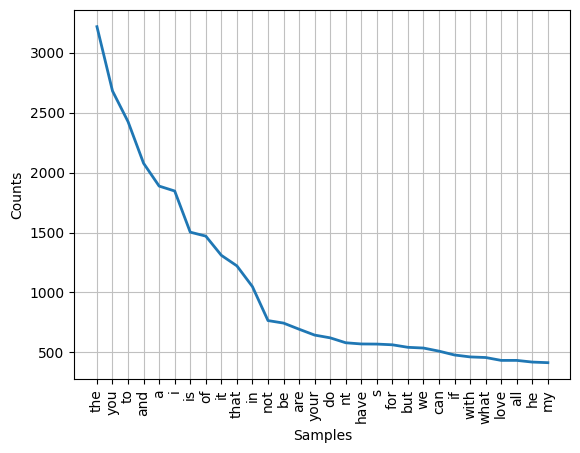

In [ ]:
li_token_lists_flat = [y for x in li_token_lists for y in x]  # flatten the list of token lists to a single list
print("li_token_lists_flat[:10]:", li_token_lists_flat[:10])

di_freq = nltk.FreqDist(li_token_lists_flat)
del di_freq['']
li_freq_sorted = sorted(di_freq.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted)

di_freq.plot(30, cumulative=False)

## Sorted frequency plot for Lemmatized  words after removing stopwords

[('love', 575), ('say', 385), ('life', 359), ('know', 313), ('thing', 311), ('make', 300), ('never', 295), ('want', 282), ('people', 278), ('time', 234), ('think', 214), ('get', 207), ('world', 200), ('book', 180), ('always', 178), ('see', 176), ('way', 165), ('live', 156), ('look', 154), ('good', 153), ('go', 150), ('come', 146), ('heart', 146), ('well', 139), ('man', 138), ('something', 137), ('give', 135), ('feel', 127), ('let', 127), ('day', 124), ('even', 121), ('someone', 119), ('nothing', 117), ('ever', 116), ('much', 114), ('take', 114), ('word', 113), ('find', 111), ('right', 110), ('person', 109), ('believe', 108), ('tell', 108), ('great', 101), ('friend', 96), ('god', 96), ('change', 95), ('read', 93), ('dream', 90), ('back', 88), ('mind', 88), ('need', 88), ('try', 86), ('little', 85), ('write', 84), ('sometimes', 83), ('woman', 79), ('lose', 78), ('anything', 77), ('learn', 77), ('really', 77), ('fall', 76), ('thought', 76), ('everything', 75), ('matter', 75), ('bad', 73),

<Axes: xlabel='Samples', ylabel='Counts'>

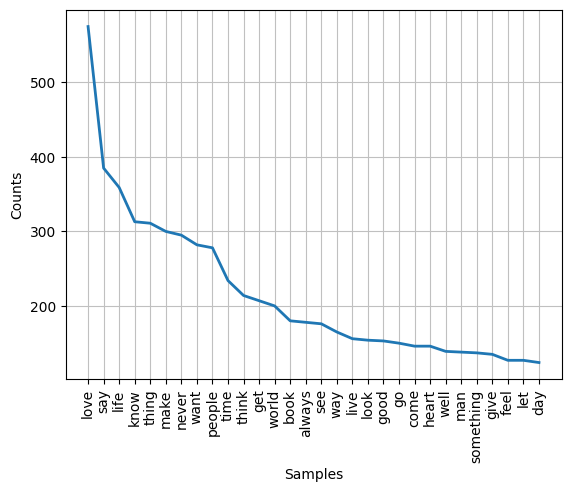

In [ ]:
li_lem_words = df_all_words['lem'].tolist()
di_freq2 = nltk.FreqDist(li_lem_words)
li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted2)

di_freq2.plot(30, cumulative=False)